In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import scipy.sparse as sp
import scipy.sparse.linalg as spla

from sklearn.neighbors import NearestNeighbors

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [2]:
fem_data = np.load("FEM_pts_comm.npz")
pts = fem_data["pts"]      # shape (N, 2)
q_true = fem_data["comm"]  # shape (N,)

N = pts.shape[0]
print("Loaded FEM data: N =", N)

Loaded FEM data: N = 6057


In [ ]:
def pairwise_sq_dists(X):
    X2 = np.sum(X**2, axis=1)
    D2 = X2[:, None] + X2[None, :] - 2 * X @ X.T
    D2[D2 < 0] = 0.0
    return D2

In [4]:
def gaussian_kernel_from_sq_dists(D2, eps):
    return np.exp(-D2 / eps)

In [5]:
def V_face(x, y):
    xa, ya = -3.0, 3.0
    xb, yb =  0.0, 4.5

    f  = (1.0 - x)**2 + (y - 0.25 * x**2)**2 + 1.0
    g1 = 1.0 - np.exp(-0.125 * ((x - xa)**2 + (y - ya)**2))
    g2 = 1.0 - np.exp(-0.25  * ((x - xb)**2 + (y - yb)**2))
    g3 = 1.2 - np.exp(-2.0   * ((x + 0.0)**2 + (y - 2.0)**2))
    g4 = 1.0 + np.exp(-2.0 * (x + 1.5)**2 - (y - 3.5)**2 - (x + 1.0)*(y - 3.5))

    return f * g1 * g2 * g3 * g4

In [7]:
def build_tmdmap_dn(pts, V_vals, beta, eps):
    xy = pts
    N = xy.shape[0]
    e0 = np.ones(N)

    # target measure
    mu = np.exp(-beta * V_vals)

    # radius^2 of neighborhood
    r2 = 9.0 * eps

    # construct kernel K as in notebook (sparse)
    K = sp.lil_matrix((N, N), dtype=float)

    for j in range(N):
        d2 = np.sum((xy - xy[j, :])**2, axis=1)
        ind = np.where(d2 < r2)[0]
        K[j, ind] = np.exp(-d2[ind] / eps)

    K = K.tocsr()

    # kernel density estimation (rho_e)
    c = 2.0 * np.pi * eps
    rho = np.array(K.sum(axis=1)).ravel() / (N * c)
    rho[rho == 0.0] = 1e-15

    # right-normalize K: multiply columns by sqrt(mu)/rho
    D_right = sp.diags(np.sqrt(mu) / rho, 0)
    K = K @ D_right

    # left-normalize K: row-normalize
    rho2 = np.array(K.sum(axis=1)).ravel()
    rho2[rho2 == 0.0] = 1e-15
    D_left = sp.diags(1.0 / rho2, 0)
    P = D_left @ K

    # generator
    L = (P - sp.eye(N)) / eps

    return L

In [8]:
def build_tmdmap_knn(pts, V_vals, beta, eps, k):
    xy = pts
    N = xy.shape[0]

    # squared distances + full Gaussian kernel
    D2 = pairwise_sq_dists(xy)
    K_full = np.exp(-D2 / eps)

    # keep k largest per row
    K_knn = np.zeros_like(K_full)
    for i in range(N):
        idx = np.argpartition(K_full[i], -k)[-k:]
        K_knn[i, idx] = K_full[i, idx]

    # symmetrize
    K = 0.5 * (K_knn + K_knn.T)
    K = sp.csr_matrix(K)

    # kernel density estimation
    c = 2.0 * np.pi * eps
    rho = np.array(K.sum(axis=1)).ravel() / (N * c)
    rho[rho == 0.0] = 1e-15

    # target measure
    mu = np.exp(-beta * V_vals)

    # right-normalize
    D_right = sp.diags(np.sqrt(mu) / rho, 0)
    K = K @ D_right

    # left-normalize (row-normalize)
    rho2 = np.array(K.sum(axis=1)).ravel()
    rho2[rho2 == 0.0] = 1e-15
    D_left = sp.diags(1.0 / rho2, 0)
    P = D_left @ K

    # generator
    L = (P - sp.eye(N)) / eps

    return L

In [ ]:
def solve_committor_with_dirichlet(L, idx_A, idx_B, qA=0.0, qB=1.0):
    N = L.shape[0]
    fixed = np.concatenate([idx_A, idx_B])
    free = np.setdiff1d(np.arange(N), fixed)

    q = np.zeros(N)
    q[idx_A] = qA
    q[idx_B] = qB

    # Partition L:
    L_ff = L[free][:, free]
    L_fb = L[free][:, fixed]

    rhs = -L_fb @ q[fixed]

    q_free = spla.spsolve(L_ff, rhs)
    q[free] = q_free
    return q

In [12]:
def ksum_statistic(pts, eps):
    D2 = pairwise_sq_dists(pts)
    K = gaussian_kernel_from_sq_dists(D2, eps)
    return K.sum()

In [6]:
beta = 3.0

# compute V on FEM grid
V_vals = V_face(pts[:, 0], pts[:, 1])   # shape (N,)
mu_vals = np.exp(-beta * V_vals)

In [10]:
minimum_a = np.array([-3.0, 3.0])
minimum_b = np.array([0.0, 4.5])
ra = 0.5
rb = 0.5

da2 = np.sum((pts - minimum_a)**2, axis=1)
db2 = np.sum((pts - minimum_b)**2, axis=1)
idx_A = np.where(da2 < ra**2)[0]
idx_B = np.where(db2 < rb**2)[0]

print("Size of A:", len(idx_A), " Size of B:", len(idx_B))

Size of A: 104  Size of B: 87


/var/folders/9l/f9spmd6j477db9mrby605jgm0000gn/T/ipykernel_5305/589420674.py:20: MatrixRankWarning: Matrix is exactly singular
  q_free = spla.spsolve(L_ff, rhs)


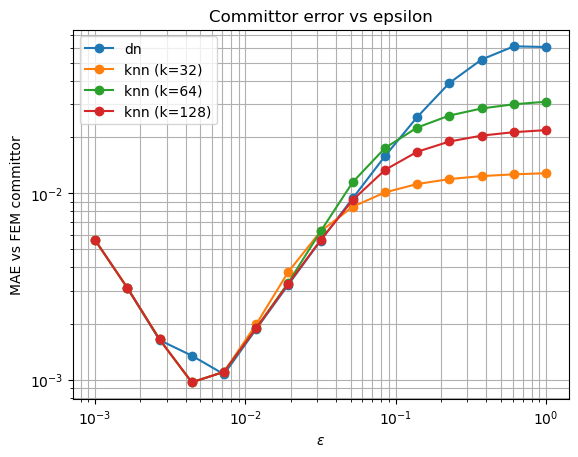

In [11]:
eps_values = np.logspace(-3, 0, 15)  # from 1e-3 to 1

mae_dn = []
mae_knn_32 = []
mae_knn_64 = []
mae_knn_128 = []

for eps in eps_values:
    # dn
    L_dn = build_tmdmap_dn(pts, V_vals, beta, eps)
    q_dn = solve_committor_with_dirichlet(L_dn, idx_A, idx_B)
    mae_dn.append(np.mean(np.abs(q_dn - q_true)))

    # knn k=32
    L_k32 = build_tmdmap_knn(pts, V_vals, beta, eps, k=32)
    q32 = solve_committor_with_dirichlet(L_k32, idx_A, idx_B)
    mae_knn_32.append(np.mean(np.abs(q32 - q_true)))

    # knn k=64
    L_k64 = build_tmdmap_knn(pts, V_vals, beta, eps, k=64)
    q64 = solve_committor_with_dirichlet(L_k64, idx_A, idx_B)
    mae_knn_64.append(np.mean(np.abs(q64 - q_true)))

    # knn k=128
    L_k128 = build_tmdmap_knn(pts, V_vals, beta, eps, k=128)
    q128 = solve_committor_with_dirichlet(L_k128, idx_A, idx_B)
    mae_knn_128.append(np.mean(np.abs(q128 - q_true)))

mae_dn = np.array(mae_dn)
mae_knn_32 = np.array(mae_knn_32)
mae_knn_64 = np.array(mae_knn_64)
mae_knn_128 = np.array(mae_knn_128)

plt.figure()
plt.loglog(eps_values, mae_dn, 'o-', label='dn')
plt.loglog(eps_values, mae_knn_32, 'o-', label='knn (k=32)')
plt.loglog(eps_values, mae_knn_64, 'o-', label='knn (k=64)')
plt.loglog(eps_values, mae_knn_128, 'o-', label='knn (k=128)')
plt.xlabel(r'$\varepsilon$')
plt.ylabel('MAE vs FEM committor')
plt.legend()
plt.title('Committor error vs epsilon')
plt.grid(True, which='both')
plt.show()

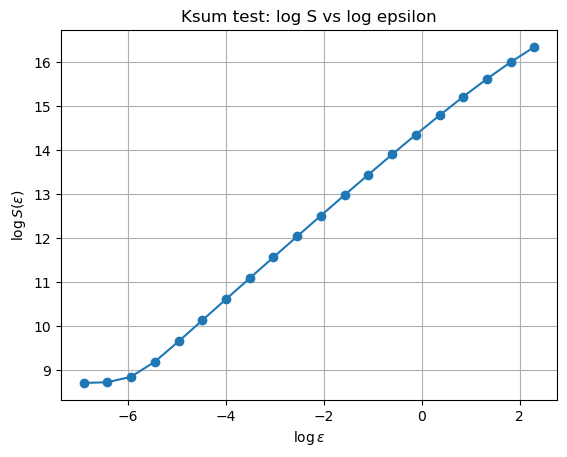

In [13]:
eps_values_ksum = np.logspace(-3, 1, 20)
S_values = np.array([ksum_statistic(pts, eps) for eps in eps_values_ksum])

plt.figure()
plt.plot(np.log(eps_values_ksum), np.log(S_values), 'o-')
plt.xlabel(r'$\log \varepsilon$')
plt.ylabel(r'$\log S(\varepsilon)$')
plt.title('Ksum test: log S vs log epsilon')
plt.grid(True)
plt.show()

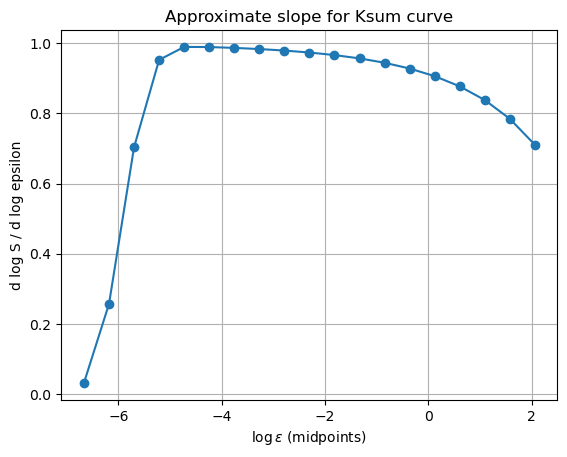

In [14]:
log_eps = np.log(eps_values_ksum)
log_S = np.log(S_values)
slopes = np.diff(log_S) / np.diff(log_eps)

plt.figure()
plt.plot((log_eps[:-1] + log_eps[1:]) / 2, slopes, 'o-')
plt.xlabel(r'$\log \varepsilon$ (midpoints)')
plt.ylabel('d log S / d log epsilon')
plt.title('Approximate slope for Ksum curve')
plt.grid(True)
plt.show()

Example epsilon* from Ksum (rough): 0.008858667904100828


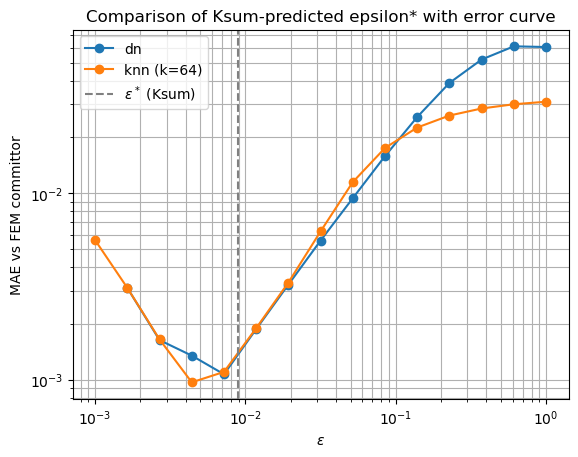

In [15]:
target_slope = 1.0
idx_star = np.argmin(np.abs(slopes - target_slope))
eps_star = np.exp((log_eps[idx_star] + log_eps[idx_star+1]) / 2)
print("Example epsilon* from Ksum (rough):", eps_star)

plt.figure()
plt.loglog(eps_values, mae_dn, 'o-', label='dn')
plt.loglog(eps_values, mae_knn_64, 'o-', label='knn (k=64)')
plt.axvline(eps_star, linestyle='--', color='gray', label=r'$\varepsilon^*$ (Ksum)')
plt.xlabel(r'$\varepsilon$')
plt.ylabel('MAE vs FEM committor')
plt.legend()
plt.grid(True, which='both')
plt.title('Comparison of Ksum-predicted epsilon* with error curve')
plt.show()